In [25]:
import numpy as np
import pandas as pd
import plotly.express as px
from darts.metrics.metrics import r2_score, smape, mae, mape
from darts.dataprocessing.transformers.scaler import Scaler
from darts.utils.missing_values import fill_missing_values
#from darts.models import RNNModel, LightGBMModel
from darts.models.forecasting.gradient_boosted_model import CatBoostModel
from darts.timeseries import TimeSeries

In [26]:
raw_data = pd.read_csv('site_id_1.csv', parse_dates=['timestamp'])

In [27]:
raw_data.head()

,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,2016-01-01 00:00:00,4154.2543,3.8,NaN,2.4,1020.9,240.0,3.1
1,2016-01-01 01:00:00,8337.2696,3.7,0.0,2.4,1021.6,230.0,2.6
2,2016-01-01 02:00:00,8317.9158,2.6,0.0,1.9,1021.9,0.0,0.0
3,2016-01-01 03:00:00,8392.4680,2.0,0.0,1.2,1022.3,170.0,1.5
4,2016-01-01 04:00:00,8109.9117,2.3,0.0,1.8,1022.7,110.0,1.5


In [28]:
#Check for missing timesteps
def is_missing_timesteps(df, date_col = 'date', freq='1H'):
    index_series  = pd.date_range(start=df[date_col][df.index[0]], end=df[date_col][df.index[-1]], freq=freq)
    return not index_series.equals(pd.Index(pd.to_datetime(df[date_col])))

In [29]:
is_missing_timesteps(raw_data, date_col='timestamp')

False

In [30]:
#So, the dataframe is missing some datetime steps, Let's extract missing timesteps
def get_missing_timesteps(df, date_col ='date', freq='H'):
    index_series = pd.date_range(start=df[date_col][df.index[0]], end=df[date_col][df.index[-1]], freq=freq)
    df_index = pd.Index(pd.to_datetime(df[date_col]))
    return index_series.difference(df_index)

In [31]:
get_missing_timesteps(raw_data, date_col='timestamp')

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [32]:
raw_data.head()

,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,2016-01-01 00:00:00,4154.2543,3.8,NaN,2.4,1020.9,240.0,3.1
1,2016-01-01 01:00:00,8337.2696,3.7,0.0,2.4,1021.6,230.0,2.6
2,2016-01-01 02:00:00,8317.9158,2.6,0.0,1.9,1021.9,0.0,0.0
3,2016-01-01 03:00:00,8392.4680,2.0,0.0,1.2,1022.3,170.0,1.5
4,2016-01-01 04:00:00,8109.9117,2.3,0.0,1.8,1022.7,110.0,1.5


In [33]:
raw_data.isnull().mean()

timestamp             0.000000
meter_reading         0.000000
air_temperature       0.002505
cloud_coverage        0.806352
dew_temperature       0.002505
sea_level_pressure    0.008311
wind_direction        0.002732
wind_speed            0.002391
dtype: float64

In [34]:
raw_data['air_temperature'] = raw_data['air_temperature'].interpolate()
raw_data['cloud_coverage'] = raw_data['cloud_coverage'].fillna(-1)
raw_data['dew_temperature'] = raw_data['dew_temperature'].interpolate()
raw_data['sea_level_pressure'] = raw_data['sea_level_pressure'].interpolate()
raw_data['wind_direction'] = raw_data['wind_direction'].interpolate()
raw_data['wind_speed'] = raw_data['wind_speed'].interpolate()

In [35]:
raw_data.isnull().mean()

timestamp             0.0
meter_reading         0.0
air_temperature       0.0
cloud_coverage        0.0
dew_temperature       0.0
sea_level_pressure    0.0
wind_direction        0.0
wind_speed            0.0
dtype: float64

In [36]:
raw_data['meter_reading'] = raw_data['meter_reading'].clip(upper=np.mean(raw_data.meter_reading) + 3*np.std(raw_data.meter_reading), lower=np.mean(raw_data.meter_reading) - 3*np.std(raw_data.meter_reading))

In [37]:
time_col = 'timestamp'
value_cols = list(raw_data.columns.drop('timestamp'))

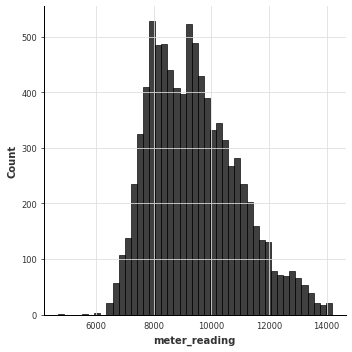

In [38]:
import seaborn as sns
sns.displot(raw_data['meter_reading'])

In [39]:
ts_data = TimeSeries.from_dataframe(raw_data, time_col='timestamp', value_cols=value_cols)

In [40]:
ts_data = ts_data.add_holidays('US')
ts_data = ts_data.add_datetime_attribute('hour', cyclic=True)
ts_data = ts_data.add_datetime_attribute('month', cyclic=True)
ts_data = ts_data.add_datetime_attribute('dayofweek', cyclic=True)
ts_data = ts_data.add_datetime_attribute('dayofyear', one_hot=True)
ts_data = ts_data.add_datetime_attribute('weekofyear', one_hot=True)

In [41]:
px.line(raw_data, x='timestamp', y=['meter_reading'])

In [42]:
px.line(raw_data, x='timestamp', y=['meter_reading'])

In [43]:
load_std = np.std(ts_data['meter_reading'])
load_std

component
meter_reading    1519.955035
dtype: float64

In [44]:
load_mean = np.mean(ts_data['meter_reading'])
load_mean

component
meter_reading    9411.852127
dtype: float64

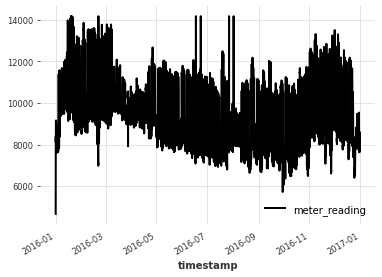

In [45]:
ts_data['meter_reading'].plot()

In [46]:
target_col = ['meter_reading']

cov_cols = list(ts_data.columns.drop(target_col))

In [47]:
train, test = ts_data.split_after(0.85)

train_target = train[target_col]
train_cov = train[cov_cols]

test_target = test[target_col]
test_cov = test[cov_cols]

In [48]:
catboost_model = CatBoostModel(
    lags=24*7,
    lags_past_covariates=24*14,
    iterations = 1500,
    loss_function='RMSEWithUncertainty',
    posterior_sampling=True,
)

In [ ]:
catboost_model.fit(train_target, past_covariates=train_cov, verbose=True)

In [ ]:
import pickle
pickle.dump(catboost_model, open('catboost_model.pkl', 'wb'))

In [ ]:
import pickle
catboost_model = pickle.load(open('catboost_model.pkl', 'rb'))

In [ ]:
pred = catboost_model.predict_distribution_from_ensemble(series=train_target, n=len(test_target), past_covariates=train_cov.append(test_cov))

In [ ]:
pred.keys()

In [ ]:
pred['mean'].plot()

In [ ]:
pred['data_std'] .plot()

In [ ]:
pred['knowledge_std'].plot()

In [ ]:
(pred['data_std'] + pred['knowledge_std']).plot()

In [ ]:
from darts.metrics.metrics import r2_score, smape, rmsle, rmse

In [ ]:
smape(test_target, pred['mean'])

In [ ]:
rmse(test_target, pred['mean'])

In [ ]:
rmsle(test_target, pred['mean'])

In [ ]:
test_target.plot(label='target')
pred['mean'].plot(label='predictions')

In [ ]:
pred_df = pd.DataFrame({'target': test_target.all_values().reshape(len(test_target)), 'prediction': pred['mean'].all_values().reshape(len(test_target))}, index=test_target.time_index)

In [ ]:
px.line(pred_df, x=pred_df.index, y=['target', 'prediction'])

In [ ]:
px.line(x=pred['data_std'].time_index, y=pred['data_std'].all_values().reshape(len(test_target)))

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=3, shared_xaxes=True)

In [ ]:
fig.add_trace(go.Scatter(x=pred['mean'].time_index, y=pred['mean'].all_values().reshape(len(test_target))), row=1, col=1)
fig.add_trace(go.Scatter(x=test_target.time_index, y=test_target.all_values().reshape(len(test_target))), row=1, col=1)
fig.add_trace(go.Scatter(x=pred['data_std'].time_index, y=pred['data_std'].all_values().reshape(len(test_target))), row=2, col=1)
fig.add_trace(go.Scatter(x=pred['knowledge_std'].time_index, y=pred['knowledge_std'].all_values().reshape(len(test_target))), row=3, col=1)